In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/20212/class/nlp/ner-vietnamese/src/CRF

/content/drive/MyDrive/20212/class/nlp/ner-vietnamese/src/CRF


In [ ]:
!pip install swifter

In [4]:
import utils

In [5]:
data_df = utils.pre_process()

Pandas Apply:   0%|          | 0/1003559 [00:00<?, ?it/s]

In [75]:
data_df

,sentence_id,words,labels
0,0,Đại,B-PERSONTYPE
1,0,diện,I-PERSONTYPE
2,0,VKS,I-PERSONTYPE
3,0,đề,O
4,0,nghị,O
...,...,...,...
985769,45988,đến,O
985770,45988,cựu,B-PERSONTYPE
985771,45988,Chủ,I-PERSONTYPE
985772,45988,tịch,I-PERSONTYPE


In [76]:
data_df[data_df['sentence_id'] ==3]

,sentence_id,words,labels


In [7]:
split_index = int(0.8* 45988)
split_index

36790

In [8]:
train = data_df[data_df.sentence_id < split_index ]
dev = data_df[data_df.sentence_id >= split_index ]

In [10]:
length_df = data_df.groupby('sentence_id').agg('count')

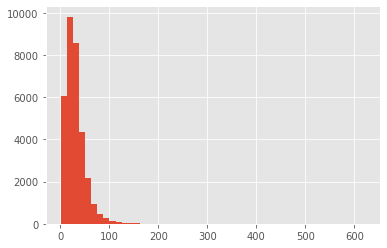

In [12]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.hist(length_df['words'], bins=50)
plt.show()

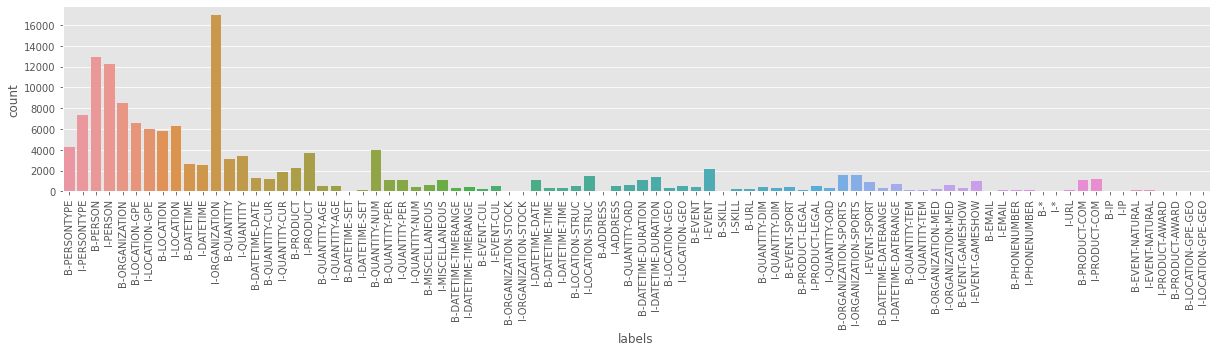

In [45]:
import seaborn as sns

plt.figure(figsize=(17, 5))

data_ner_non_null = data_df.drop(data_df[data_df['labels'] == 'O'].index)

ax = sns.countplot('labels', data=data_ner_non_null)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [46]:
!pip install sklearn-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 5.2 MB/s 


In [47]:
from itertools import chain

import nltk
import sklearn
import scipy.stats

import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics

In [51]:
def word2features(sent, i):
    word = sent[i][0] 

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(), 
    }
    if i > 0:
        word1 = sent[i-1][0] 
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(), 
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0] 
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(), 
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

In [78]:
train_data=data_df.copy()

In [79]:
train_data

,sentence_id,words,labels
0,0,Đại,B-PERSONTYPE
1,0,diện,I-PERSONTYPE
2,0,VKS,I-PERSONTYPE
3,0,đề,O
4,0,nghị,O
...,...,...,...
985769,45988,đến,O
985770,45988,cựu,B-PERSONTYPE
985771,45988,Chủ,I-PERSONTYPE
985772,45988,tịch,I-PERSONTYPE


In [80]:
train_data[train_data['sentence_id'] == 3]

,sentence_id,words,labels


In [81]:
# train1[] = train_data.groupby('sentence_id')
import pandas as pd 
train1 = pd.DataFrame()
train1['pair'] = train_data.apply(lambda row: (row.words,row.labels), axis=1)
train1['id_sent'] = train_data['sentence_id']

In [82]:
train1

,pair,id_sent
0,"(Đại, B-PERSONTYPE)",0
1,"(diện, I-PERSONTYPE)",0
2,"(VKS, I-PERSONTYPE)",0
3,"(đề, O)",0
4,"(nghị, O)",0
...,...,...
985769,"(đến, O)",45988
985770,"(cựu, B-PERSONTYPE)",45988
985771,"(Chủ, I-PERSONTYPE)",45988
985772,"(tịch, I-PERSONTYPE)",45988


In [83]:
train2 = pd.DataFrame()
train2['data'] = train1.groupby('id_sent')['pair'].apply(list)

In [84]:
train2

,data
id_sent,
0,"[(Đại, B-PERSONTYPE), (diện, I-PERSONTYPE), (V..."
1,"[(Cựu, B-PERSONTYPE), (thư, I-PERSONTYPE), (ký..."
2,"[(Một, O), (số, O), (giám, B-PERSONTYPE), (đốc..."
4,"[(Thanh, B-PERSONTYPE), (niên, I-PERSONTYPE), ..."
5,"[(HĐXX, B-ORGANIZATION), (xét, O), (xử, O), (đ..."
...,...
45981,"[(Khi, O), (hoàn, O), (thành, O), (sửa, O), (c..."
45983,"[(Cũng, O), (theo, O), (đại, O), (diện, O), (S..."
45985,"[(Trước, O), (đó, O), (,, O), (như, O), (báo, ..."


In [85]:
train3 = train2['data'].tolist()

In [86]:
len(train3)

32950

In [89]:
X = [sent2features(s) for s in train3]
y = [sent2labels(s) for s in train3]

In [95]:
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=1,
          max_iterations=100,
          all_possible_transitions=False)

In [91]:
train_index = int(len(y)*0.8)
train_index

26360

In [92]:
X_train = X[0:train_index]
X_test = X[train_index+1:]

y_train = y[0:train_index]
y_test = y[train_index+1:]

In [ ]:
crf.fit(X_train, y_train)

In [98]:
labels= ['B-PERSONTYPE',
  'B-PERSON',
  'B-ORGANIZATION',
  'B-LOCATION-GPE',
  'B-LOCATION',
  'B-DATETIME',
  'B-QUANTITY',
  'B-DATETIME-DATE',
  'B-PRODUCT',
  'B-QUANTITY-AGE',
  'B-DATETIME-SET',
  'B-QUANTITY-NUM',
  'B-MISCELLANEOUS',
  'B-QUANTITY-PER',
  'B-DATETIME-TIMERANGE',
  'B-EVENT-CUL',
  'B-QUANTITY-CUR',
  'B-ORGANIZATION-STOCK',
  'B-DATETIME-TIME',
  'B-LOCATION-STRUC',
  'B-ADDRESS',
  'B-QUANTITY-ORD',
  'B-DATETIME-DURATION',
  'B-LOCATION-GEO',
  'B-EVENT',
  'B-SKILL',
  'B-URL',
  'B-QUANTITY-DIM',
  'B-EVENT-SPORT',
  'B-PRODUCT-LEGAL',
  'B-ORGANIZATION-SPORTS',
  'B-DATETIME-DATERANGE',
  'B-QUANTITY-TEM',
  'B-ORGANIZATION-MED',
  'B-EVENT-GAMESHOW',
  'B-EMAIL',
  'B-PHONENUMBER',
  'B-PRODUCT-COM',
  'B-IP',
  'B-EVENT-NATURAL',
  'B-PRODUCT-AWARD']

In [99]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.49283703930290673

In [101]:
flat_true =[]
flat_pred =[]
for sent in y_test:
  for x in sent:
    flat_true.append(x)

for sent in y_pred:
  for x in sent:
    flat_pred.append(x)

In [102]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

labels.sort()
import sklearn
print(sklearn.metrics.classification_report(
    flat_true, flat_pred, labels=labels, digits=3
))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

                       precision    recall  f1-score   support

            B-ADDRESS      0.000     0.000     0.000         1
           B-DATETIME      0.712     0.601     0.652       966
      B-DATETIME-DATE      0.421     0.383     0.401       188
 B-DATETIME-DATERANGE      0.040     0.015     0.022        67
  B-DATETIME-DURATION      0.586     0.748     0.657       206
       B-DATETIME-SET      0.000     0.000     0.000         1
      B-DATETIME-TIME      0.320     0.333     0.327        24
 B-DATETIME-TIMERANGE      0.000     0.000     0.000        34
              B-EMAIL      0.500     1.000     0.667         1
              B-EVENT      0.130     0.091     0.107        33
          B-EVENT-CUL      0.333     0.071     0.118        28
     B-EVENT-GAMESHOW      0.235     0.267     0.250        15
      B-EVENT-NATURAL      0.000     0.000     0.000         0
        B-EVENT-SPORT      0.483     0.359     0.412        39
                 B-IP      0.000     0.000     0.000  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [121]:
flat_true_coff = []
flat_preds_coff = []

for sent in y_test:
  for x in sent:
    if '-' in x:
        x = x.split('-')[1]
    flat_true_coff.append(x) 

for sent in y_pred:
  for x in sent:
    if '-' in x:
        x = x.split('-')[1]
    flat_preds_coff.append(x) 

print(len(flat_preds_coff))
print(len(flat_true_coff))

label_rm_begin = []
for x in labels:
    if '-' in x:
        x = x.split('-')[1]
    label_rm_begin.append(x)



label_rm_begin = list(set(label_rm_begin))

label_rm_begin.sort()



215819
215819


In [124]:
x = set(label_rm_begin)

In [141]:
label_rm_begin

['ADDRESS',
 'DATETIME',
 'EMAIL',
 'EVENT',
 'IP',
 'LOCATION',
 'MISCELLANEOUS',
 'ORGANIZATION',
 'PERSON',
 'PERSONTYPE',
 'PHONENUMBER',
 'PRODUCT',
 'QUANTITY',
 'SKILL',
 'URL']

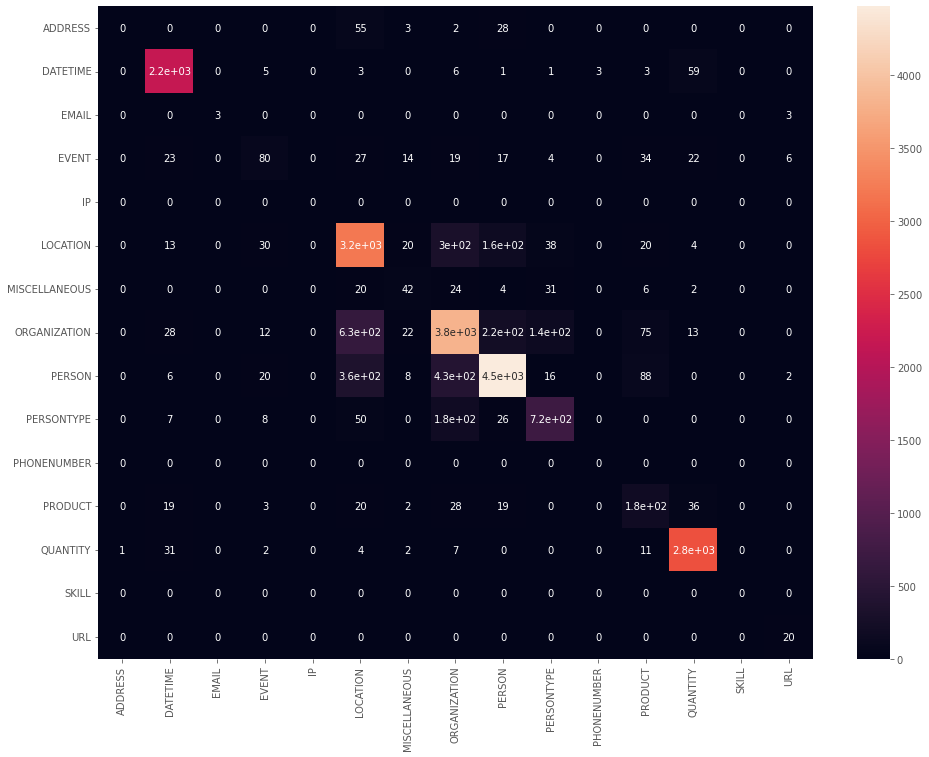

In [152]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(flat_preds_coff, flat_true_coff, labels=label_rm_begin)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, xticklabels=label_rm_begin, yticklabels=label_rm_begin)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_rm_begin)

# disp.plot(ax=ax)
# plt.xticks(rotation = 90)
# plt.show()  
